In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
import re
# from multiprocessing import Pool, cpu_count
import pickle
from tifffile import imread
from scipy.sparse import csr_matrix

# TODO
# 1. use imread to read tiff files
# 2. try pickle

In [2]:
def grouping_intensity_values(image_array, bin_width=1):
    # 1. image_array is a list of zero or positive integers. 
    # 2. returns will be a list from 0 to the max of image_array, and another list of how many elements having the value in the first list respectively. 
    # 3. returns should be ready for a bar plot. 
    max_value = np.max(image_array)

    bins = np.arange(0, max_value + bin_width, bin_width)
    pixels, _ = np.histogram(image_array, bins=bins)
    bins = bins[:-1]

    if debug==True:
        print('bins:', bins)
        print('pixels:', pixels)

    return bins, pixels

In [3]:
def get_tiff_list(tiff_path):
    file_names = os.listdir(tiff_path)
    tiff_files = [f for f in file_names if f.lower().endswith('.tif') or f.lower().endswith('.tiff')]
    return tiff_files

In [24]:
def read_all_images(tiff_path, reader='PIL', sparse=True):
    # img = Image.open(f'{tiff_path}\\{file_name}')
    # img_array = np.array(img)

    tiff_filenames = get_tiff_list(tiff_path)
    image_arrays = []
    
    # check if pickle file image_arrays.pkl exists in the tiff_path
    # if yes, load it
    # if not, read tiff files and save it as pickle file
    if os.path.exists(f'{tiff_path}\\image_arrays.pkl'):
        with open(f'{tiff_path}\\image_arrays.pkl', 'rb') as f:
            image_arrays = pickle.load(f)
        print(f'{tiff_path}\nLoaded image_arrays.pkl')

    else:
        start_time = time.time()
        if reader=='PIL':
            # img_first = Image.open(f'{tiff_path}\\{tiff_filenames[0]}')
            # image_arrays = np.zeros_like(img_first, dtype=np.float64)

            # File reading time: 658.416844367981 seconds
            for file_name in tiff_filenames:
                # 只处理tif文件
                if file_name.endswith('.tif'):
                    img = Image.open(f'{tiff_path}\\{file_name}')
                    img_array = np.array(img)
                    if sparse==True:
                        img_array = csr_matrix(img_array)
                    image_arrays.append(img_array)
            print('With PIL')

            with open(f'{tiff_path}\\image_arrays.pkl', 'wb') as f:
                pickle.dump(image_arrays, f)

        elif reader=='tifffile':
        #     # img_first = imread(f'{tiff_path}\\{tiff_filenames[0]}')
        #     # image_arrays = np.zeros_like(img_first, dtype=np.float64)

        #     # File reading time: 766.2443685531616 seconds
        #     for file_name in tiff_filenames:
        #         if file_name.endswith('.tif'):
        #             img_array = imread(f'{tiff_path}\\{file_name}')
        #             image_arrays.append(img_array)
            print('With tifffile')

        end_time = time.time()
        print(f'File reading time: {end_time - start_time} seconds')

    if debug==True:
        print('sparse', sparse)

    
    return image_arrays

In [21]:
def sum_all_images(tiff_path):

    image_arrays = read_all_images(tiff_path)
    
    if os.path.exists(f'{tiff_path}\\sum_image_arrays.pkl'):
        with open(f'{tiff_path}\\sum_image_arrays.pkl', 'rb') as f:
            sum_image = pickle.load(f)
        print('Loaded sum_image_arrays.pkl')

    else:
        sum_image = np.zeros_like(image_arrays[0], dtype=np.float64)
        for img in image_arrays:
            sum_image += img
        with open(f'{tiff_path}\\sum_image_arrays.pkl', 'wb') as f:
            pickle.dump(sum_image, f)
        
    return sum_image

In [5]:
def total_pixel_values(sum_image_arrays, tiff_path, plot_type, bin_amount=20, save=False):

    tiff_filenames = get_tiff_list(tiff_path)

    # start_time = time.time()

    # region get tags from img_first
    # image_first = imread(f'{tiff_path}\\{tiff_filenames[0]}')
    image_first = Image.open(f'{tiff_path}\\{tiff_filenames[0]}')
    # image_arrays = np.zeros_like(image_first, dtype=np.float64)

    # tag 270 Image description
    tag_content = image_first.tag_v2.get(270)

    # Extract exposure time using regular expression
    match = re.search(r'Prop_ExposureTime2=([\d.]+)', tag_content)
    if match:
        exposure_time_str = match.group(1)
        exposure_time_ms = float(exposure_time_str) * 1000
        if debug==True:
            print(f'exposure time match {match}')
            print(f"Exposure time: {exposure_time_ms:.0f} ms")
    else:
        if debug==True:
            print("Exposure time not found in tag 270")

    # tag 258 bit rate (16,) 
    bit_rate = image_first.tag_v2.get(258)
    if debug==True:
        print(f"Bit rate: {bit_rate[0]} bits")

    # tag 256 image width tag 257 image length
    image_width = image_first.tag_v2.get(256)
    image_length = image_first.tag_v2.get(257)
    # image_dimension = str(image_first.tag_v2.get(256)) + "x" + str(image_first.tag_v2.get(257))
    image_dimension = str(image_width) + "x" + str(image_length)
    if debug==True:
        print(f"Dimension: {image_dimension}")
        print(f'{np.sum(sum_image_arrays==0)} pixels had 0 count {np.sum(sum_image_arrays==0) / (image_width * image_length) * 100:.1f}%')
        print(f'{np.sum(sum_image_arrays==1)} had 1 count {np.sum(sum_image_arrays==1) / (image_width * image_length) * 100:.1f}%')
        print(f'Total amount of pixels: {image_width * image_length}')
    # endregion
        
    # if reader=='PIL':
    #     # File reading time: 658.416844367981 seconds
    #     for file_name in tiff_filenames:
    #         # 只处理tif文件
    #         if file_name.endswith('.tif'):
    #             img = Image.open(f'{tiff_path}\\{file_name}')
    #             img_array = np.array(img)
    #             image_arrays += img_array
    #     print('With PIL')
    # elif reader=='tifffile':
    #     # File reading time: 766.2443685531616 seconds
    #     for file_name in tiff_filenames:
    #         if file_name.endswith('.tif'):
    #             img_array = imread(f'{tiff_path}\\{file_name}')
    #             image_arrays += img_array
    #     print('With tifffile')
    # end_time = time.time()
    # if debug==True:
    #     print(f"File reading time: {end_time - start_time} seconds")

    if debug==True:
        frames = len(tiff_filenames)
        print('exposures:', frames)
    if debug==True:
        print('Maximum value of image_arrays:', np.max(sum_image_arrays))


    if plot_type == 'heat':
        fig = plt.figure(figsize=(10, 6))
        plt.imshow(sum_image_arrays, cmap='hot', interpolation='nearest')
        plt.colorbar(label='Pixel Value (Sum)')
        fig.text(0.5, 0.01, f'Exposure time: {exposure_time_ms:.0f} ms, Bit rate: {bit_rate[0]} bits, Dimension: {image_dimension}, frames: {len(tiff_filenames)}', ha='center') # Add caption to the figure
        if save==True:
            plt.savefig('total_pixel_cmap.png')
        plt.show()

    elif plot_type == 'bar':
        # bins = max(int(0.1*frames), 20) # Set bins amount. if bins is less than 20, set it to there
        counts, bin_edges = np.histogram(sum_image_arrays.flatten(), bins=bin_amount)
        if debug==True:
            # print('bin amount:', bin_amount)
            print(f'bin amount: {bin_amount}')
            max_fraction_bin = np.max(counts) / np.sum(counts)
            print(f'{100*max_fraction_bin:.1f}% of pixels counted between {np.argmax(counts)} and {np.argmax(counts) + np.diff(bin_edges)[0]} in all {len(tiff_filenames)} frames')
            # print the amount of pixels in image_arrays that has 0

        counts_normalized = counts / counts.max()
        # has to be printed on every branches of if-else
        # because bins height normalization is done in different ways
        # if debug==True:
        #     print('Mininum in counts_normalized:', np.min(counts_normalized[counts_normalized > 0]))
        if debug==True:
            # min_value = np.min(counts_normalized[counts_normalized > 0])
            print('Minimum in counts_normalized: %.e' % np.min(counts_normalized[counts_normalized > 0]))

        fig = plt.figure(figsize=(10, 6))
        plt.bar(bin_edges[:-1], counts_normalized, width=np.diff(bin_edges), color='gray', log=True, align='edge')

        if debug==True:
            # print('bins:', bin_edges[:-1])
            # print('freq_array:', counts_normalized)
            print('bins width:', np.average(np.diff(bin_edges)))

        # bars = plt.bar(bins, freq_arrays_normalized, color='gray')

        # xticks = np.arange(0, int(value_max)) # 生成一个从x轴的最小值到最大值的整数序列
        # plt.xticks(xticks) # 设置x轴的刻度

        # # 在每个柱子上方添加一个文本标签
        # for bar in bars:
        #     height = bar.get_height()
        #     plt.text(bar.get_x() + bar.get_width() / 2, height, 
        #             f'{height:.1f}', ha='center', va='bottom')

        # plt.title(f'Histogram of Total Counts v.s. Amount of Pixels after {len(freq_arrays)} exposures')
        plt.xlabel('Counts')
        plt.ylabel('Frequency (normalized)')
        
        fig.text(0.15, 0.01, f'Exposure time: {exposure_time_ms:.0f} ms, Bit rate: {bit_rate[0]} bits, Dimension: {image_dimension}, frames: {len(tiff_filenames)}\n' \
            f'{np.sum(sum_image_arrays==0)} pixels had 0 count in total, {np.sum(sum_image_arrays==0) / (image_width * image_length) * 100:.1f}%; ' \
            f'{np.sum(sum_image_arrays==1)} pixels had 1 count, {np.sum(sum_image_arrays==1) / (image_width * image_length) * 100:.1f}%\n' \
            f'10% of the pixels had less than {np.percentile(sum_image_arrays, 10):.0f} counts, 10% of the pixels had more than {np.percentile(sum_image_arrays, 90):.0f} counts' \
            , ha='left')
        plt.subplots_adjust(bottom=0.18)

        if save==True:
            plt.savefig('total_pixel_values.png')

        # 显示图表
        plt.show()

    elif plot_type=="hist":
        if debug==True:
            print('Minimum non-zero value of image_arrays: %.e' % np.min(sum_image_arrays[sum_image_arrays > 0]))

        fig = plt.figure(figsize=(10, 6))
        bin_amount = max(int(0.1*frames), 20) # Set bins amount. if bins is less than 20, set it to there
        if debug==True:
            print('amount of bins:', bin_amount)
        hist = plt.hist(sum_image_arrays.flatten(), bins=bin_amount, color='gray', log=True)
        if debug==True:
            print('hist:', hist)

        plt.xlabel('Counts')
        plt.ylabel('Frequency')
        fig.text(0.5, 0.01, f'Exposure time: {exposure_time_ms} ms, Bit rate: {bit_rate[0]} bits, Dimension: {image_dimension}, frames: {len(tiff_filenames)}', ha='center') # Add caption to the figure
        if save==True:
            plt.savefig('total_pixel_values.png')
        # 显示图表
        plt.show()

In [15]:
debug = True
tiff_main_folder = 'W:\\Quant_Opt_Group\\Group\\Zhengyin_public\\LABDATA\\3.12 qCMOS\\data'
# tiff_main_folder = 'C:\\3.12 qCMOS'
print(tiff_main_folder)

W:\Quant_Opt_Group\Group\Zhengyin_public\LABDATA\3.12 qCMOS\data


In [7]:
tiff_path_124 = 'W:\\Quant_Opt_Group\\Group\\Zhengyin_public\\LABDATA\\3.12 qCMOS\\data' + '\\3056x124'
# With tifffile
# File reading time: 1184.8728506565094 seconds
image_arrays_124 = read_all_images(tiff_path_124)

With PIL
File reading time: 963.0234820842743 seconds


In [8]:
sum_image_arrays_124 = np.sum(image_arrays_124, axis=0)

exposure time match <re.Match object; span=(2839, 2867), match='Prop_ExposureTime2=0.0115776'>
Exposure time: 12 ms
Bit rate: 16 bits
Dimension: 3056x124
338 pixels had 0 count 0.1%
990 had 1 count 0.3%
Total amount of pixels: 378944
exposures: 6000
Maximum value of image_arrays: 17936
bin amount: 100
73.6% of pixels counted between 0 and 179.36 in all 6000 frames
Minimum in counts_normalized: 4e-06
bins width: 179.36


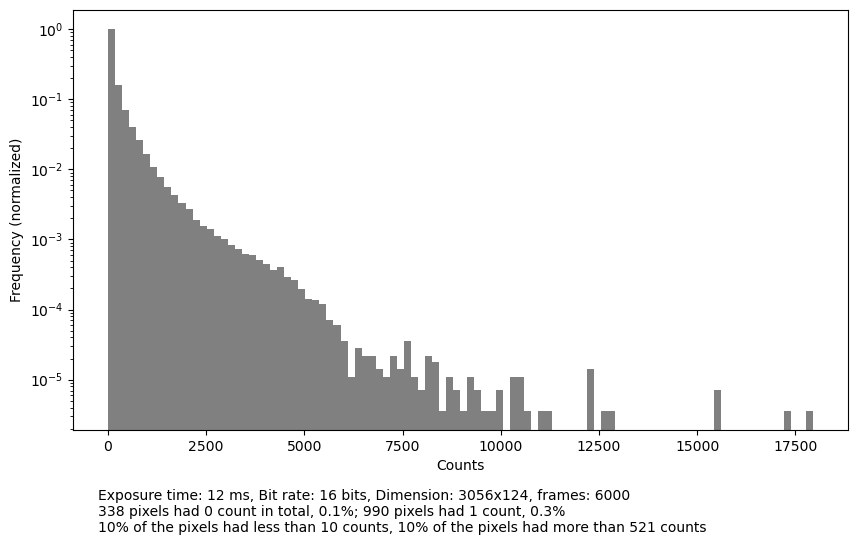

In [9]:
total_pixel_values(sum_image_arrays_124, tiff_path_124, 'bar', bin_amount=100, save=True)

In [25]:
# With PIL
# File reading time: 529.5468378067017 seconds
# File reading time: 288.56911730766296 seconds
# tiff_path_1s = 'W:\\Quant_Opt_Group\\Group\\Zhengyin_public\\LABDATA\\3.12 qCMOS\\data' + '\\1s'
tiff_path_1s = tiff_main_folder + '\\1s'
# image_arrays_1s = read_all_images(tiff_path_1s, reader='PIL')
sum_image_arrays_1s = sum_all_images(tiff_path_1s)

W:\Quant_Opt_Group\Group\Zhengyin_public\LABDATA\3.12 qCMOS\data\1s
Loaded image_arrays.pkl
sparse True
Loaded sum_image_arrays.pkl


In [10]:
# sum_image_arrays_1s = np.sum(image_arrays_1s, axis=0)

In [13]:
# 从文件中加载稀疏矩阵
with open(tiff_path_1s + '/image_arrays_1s.pkl', 'rb') as f:
    sparse_matrix = pickle.load(f)

exposure time match <re.Match object; span=(2840, 2860), match='Prop_ExposureTime2=1'>
Exposure time: 1000 ms
Bit rate: 16 bits
Dimension: 4096x124
31 pixels had 0 count 0.0%
55 had 1 count 0.0%
Total amount of pixels: 507904
exposures: 6000
Maximum value of image_arrays: 67172
bin amount: 100
91.5% of pixels counted between 0 and 671.72 in all 6000 frames
Minimum in counts_normalized: 2e-06
bins width: 671.72


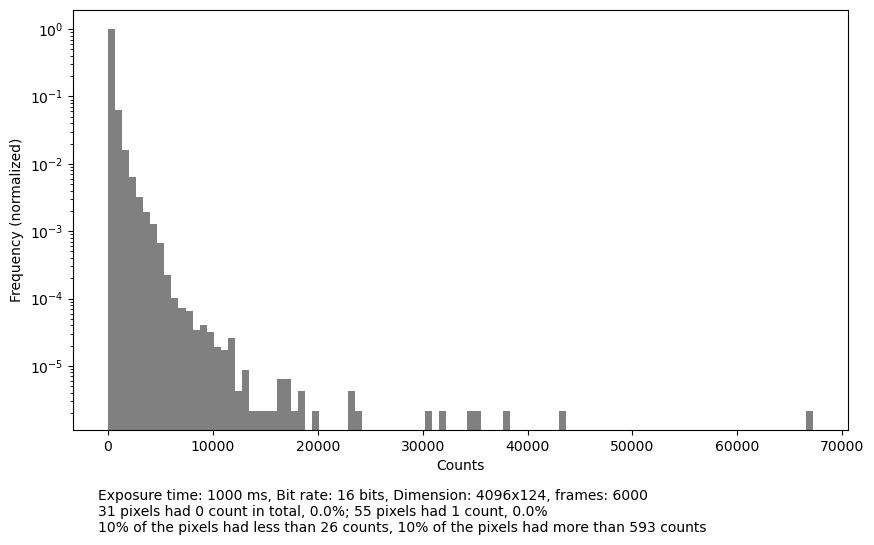

In [12]:
total_pixel_values(sum_image_arrays_1s, tiff_path_1s, 'bar', bin_amount=100, save=True)

With PIL
File reading time: 9.137742519378662 seconds
exposure time match <re.Match object; span=(2845, 2873), match='Prop_ExposureTime2=0.0893376'>
Exposure time: 89 ms
Bit rate: 16 bits
Dimension: 1024x1024
538042 pixels had 0 count 51.3%
210207 had 1 count 20.0%
Total amount of pixels: 1048576
exposures: 50
Maximum value of image_arrays: 210
bin amount: 100
80.7% of pixels counted between 0 and 2.1 in all 50 frames
Minimum in counts_normalized: 1e-06
bins width: 2.1


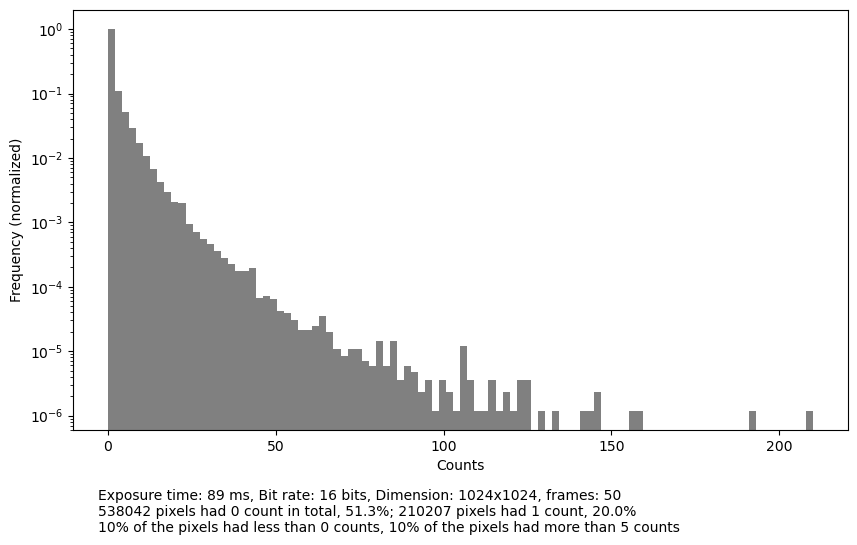

In [13]:
tiff_path_quick = 'W:\\Quant_Opt_Group\\Group\\Zhengyin_public\\LABDATA\\3.12 qCMOS\\data' + '\\1024x1024_quick'
image_arrays_quick = read_all_images(tiff_path_quick, reader='PIL')
sum_image_arrays_quick = np.sum(image_arrays_quick, axis=0)
total_pixel_values(sum_image_arrays_quick, tiff_path_quick, 'bar', bin_amount=100, save=False)

In [ ]:
tiff_path_1s_full = 'W:\\Quant_Opt_Group\\Group\\Zhengyin_public\\LABDATA\\3.12 qCMOS\\data' + '\\full_1s_6000_shot'
image_arrays_1s_full = read_all_images(tiff_path_1s_full, reader='PIL')